## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install pandas_profiling 
import pandas_profiling 
import scipy.stats as stats
import statsmodels as sm
%matplotlib inline

import sklearn as sk

plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['axes.grid'] = True

import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

In [2]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### Dataset

In [3]:
credit_card=pd.read_excel('C:/Users/Yash/Desktop/STATS/CASE STUDY FOR ML/1. Predicting Credit Card Spend & Identifying Key Drivers/Data Set.xlsx')
credit_card.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


In [4]:
#pandas_profiling.ProfileReport(credit_card)

In [5]:
#import sweetviz

In [6]:
#my_report = sweetviz.analyze([credit_card, "credit_card"])

In [7]:
#my_report.show_html('Report.html')

In [8]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


# Data Cleaning

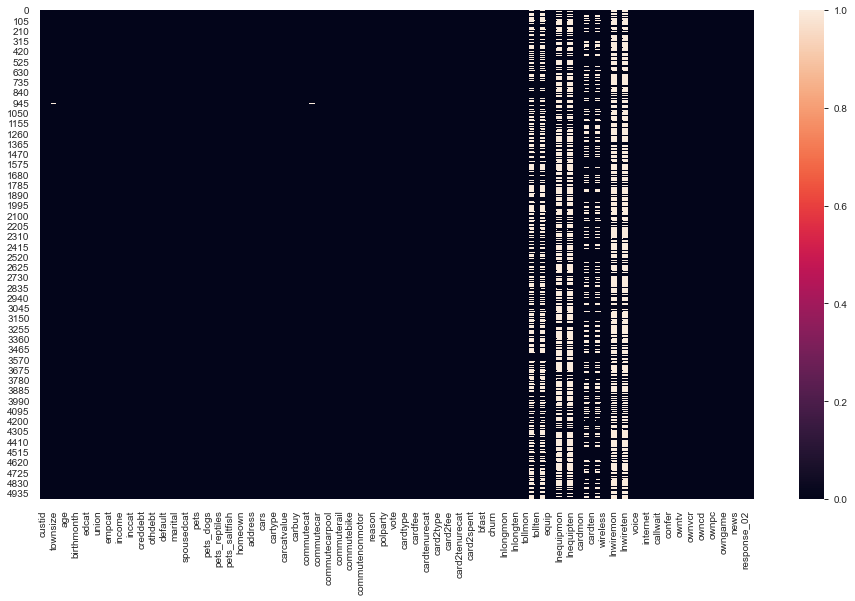

In [9]:
# Show the null values using heatmap
plt.figure(figsize=(16,9))
sns.heatmap(credit_card.isnull())

In [10]:
credit_card.isnull().sum()

custid         0
region         0
townsize       2
gender         0
age            0
              ..
ownfax         0
news           0
response_01    0
response_02    0
response_03    0
Length: 130, dtype: int64

In [11]:
miss_val_per = credit_card.isnull().mean()*100
miss_val_per

custid         0.00
region         0.00
townsize       0.04
gender         0.00
age            0.00
               ... 
ownfax         0.00
news           0.00
response_01    0.00
response_02    0.00
response_03    0.00
Length: 130, dtype: float64

In [12]:
credit_card.drop(columns=['custid','birthmonth'],inplace=True)

In [13]:
credit_card.drop(columns=['lnwiremon','lnwireten','lnequipten','lnequipmon','lntollten','lntollmon','lncardten','lncardmon'],inplace=True)

In [14]:
credit_card.columns

Index(['region', 'townsize', 'gender', 'age', 'agecat', 'ed', 'edcat',
       'jobcat', 'union', 'employ',
       ...
       'owncd', 'ownpda', 'ownpc', 'ownipod', 'owngame', 'ownfax', 'news',
       'response_01', 'response_02', 'response_03'],
      dtype='object', length=120)

In [15]:
for x in ['gender','jobcat', 'union','retire','default','marital','homeown','hometype','carown','cartype','carcatvalue','carbought','carbuy',
                 'commutecat','reason','polview','card','cardtype','cardbenefit','cardfee','cardtenurecat','card2','card2type','card2benefit','card2fee',
                 'card2tenurecat','bfast','internet']:
    credit_card[x] = credit_card[x].astype('object')

In [16]:
credit_card[x]

0       0
1       4
2       0
3       2
4       3
       ..
4995    0
4996    0
4997    0
4998    3
4999    0
Name: internet, Length: 5000, dtype: object

In [17]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 120 entries, region to response_03
dtypes: float64(23), int64(69), object(28)
memory usage: 4.6+ MB


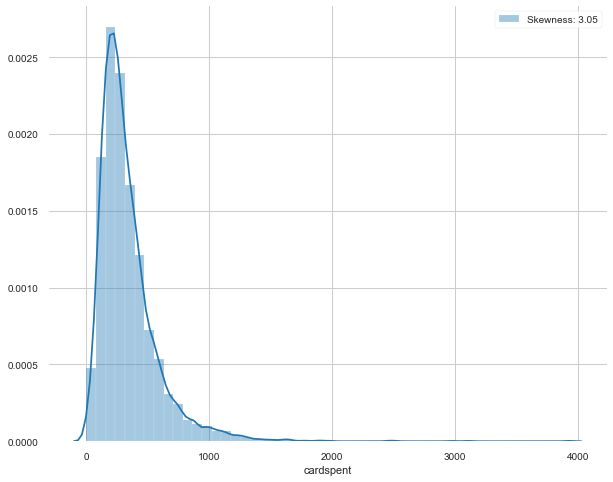

In [18]:
# Plot the distplot of target
plt.figure(figsize=(10,8))
bar = sns.distplot(credit_card["cardspent"])
bar.legend(["Skewness: {:.2f}".format(credit_card['cardspent'].skew())])

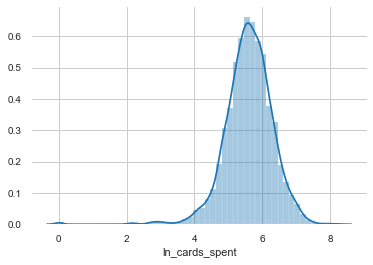

In [19]:
credit_card['ln_cards_spent']=np.log(credit_card['cardspent']+1)
sns.distplot(credit_card.ln_cards_spent)
plt.show()

In [20]:
# correlation heatmap of higly correlated features with SalePrice
hig_corr = credit_card.corr()
hig_corr_features = hig_corr.index[abs(hig_corr["cardspent"]) >= 0.5]
hig_corr_features


Index(['cardspent', 'card2spent', 'ln_cards_spent'], dtype='object')

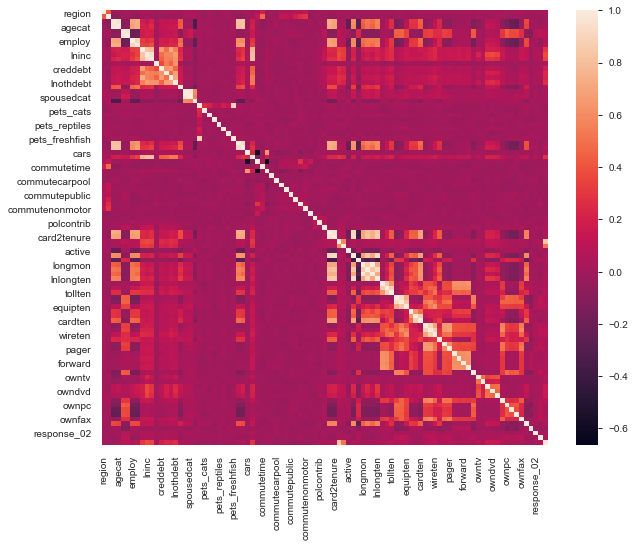

In [21]:
# heatmap showing correlation
plt.figure(figsize = (10, 8))
sns.heatmap(credit_card.corr())

(3.5, -0.5)

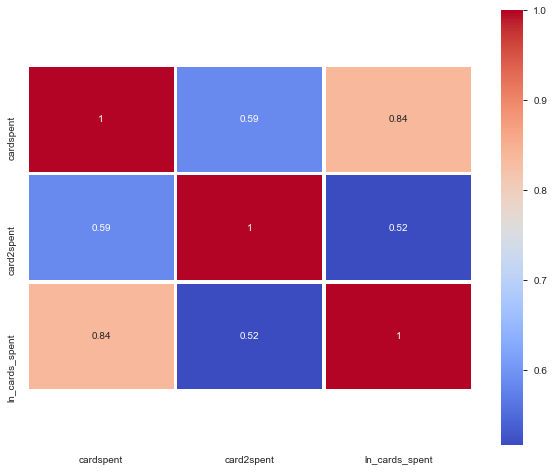

In [22]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(credit_card[hig_corr_features].corr(), cmap = "coolwarm", annot=True, linewidth=3)
# to fix the bug "first and last row cut in half of heatmap plot"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

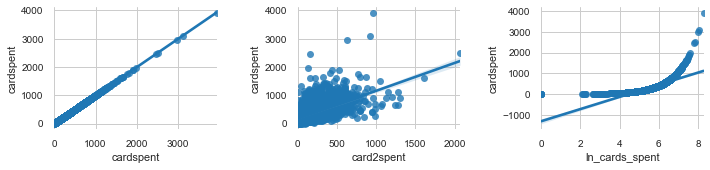

In [23]:
# Plot regplot to get the nature of highly correlated data
plt.figure(figsize=(16,9))
for i in range(len(hig_corr_features)):
    if i <= 9:
        plt.subplot(3,4,i+1)
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
        sns.regplot(data=credit_card, x = hig_corr_features[i], y = 'cardspent')

In [24]:
#seprate cat from cont

In [25]:
conti_vars=credit_card.select_dtypes(['float64','int64'])
cat_vars=credit_card.select_dtypes('object')

In [26]:
conti_vars.head()

,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,...,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,ln_cards_spent
0,1,2.0,20,2,15,3,0,1,31,3.433987,...,0,0,1,1,0,0,0,1,0,4.414736
1,5,5.0,22,2,17,4,0,1,15,2.708050,...,1,1,1,1,1,1,0,0,0,3.775057
2,3,4.0,67,6,14,2,16,5,35,3.555348,...,0,0,0,0,0,1,0,0,0,5.221544
3,4,3.0,23,2,16,3,0,1,20,2.995732,...,0,1,1,1,0,1,1,0,0,5.834781
4,2,2.0,26,3,16,3,1,1,23,3.135494,...,0,1,0,1,0,0,0,1,0,5.545568


In [27]:
cat_vars.head()

,gender,jobcat,union,retire,default,marital,homeown,hometype,carown,cartype,...,cardbenefit,cardfee,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenurecat,bfast,internet
0,1,1,1,0,1,0,0,2,1,0,...,1,0,2,5,3,1,0,2,3,0
1,0,2,0,0,1,0,1,3,1,1,...,1,0,2,4,1,3,0,2,1,4
2,1,2,0,0,0,1,1,1,1,1,...,4,0,5,4,1,3,0,5,3,0
3,0,2,0,0,1,1,1,3,1,1,...,4,0,2,3,2,4,0,2,1,2
4,0,2,0,0,0,1,0,2,0,1,...,1,0,3,1,3,2,0,3,3,3


In [28]:
# summary of continuous variables
conti_vars.apply(continuous_var_summary).T.sort_values('NMISS',ascending=False).head(10)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
longten,4997.0,3.0,3.542232e+06,708.871753,350.000000,979.291072,959011.004250,0.900000,2.400000,12.620000,28.290000,104.600000,350.000000,913.850000,1808.840000,2567.650000,4689.066000,13046.500000
lnlongten,4997.0,3.0,2.803966e+04,5.611298,5.857933,1.649308,2.720218,-0.105361,0.875469,2.535272,3.342505,4.650144,5.857933,6.817666,7.500441,7.850745,8.452988,9.476275
townsize,4998.0,2.0,1.343100e+04,2.687275,3.000000,1.425925,2.033262,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,4.000000,5.000000,5.000000,5.000000,5.000000
cardten,4998.0,2.0,3.600951e+06,720.478391,425.000000,922.225527,850499.921936,0.000000,0.000000,0.000000,0.000000,0.000000,425.000000,1080.000000,1871.500000,2455.750000,4011.200000,13705.000000
commutetime,4998.0,2.0,1.266770e+05,25.345538,25.000000,5.879149,34.564390,8.000000,13.000000,16.000000,18.000000,21.000000,25.000000,29.000000,33.000000,35.000000,40.030000,48.000000
lnothdebt,4999.0,1.0,3.483879e+03,0.696915,0.741537,1.128578,1.273689,-4.092107,-2.168241,-1.243483,-0.780312,-0.018987,0.741537,1.462053,2.087178,2.469586,3.180802,4.952011
lncreddebt,4999.0,1.0,-6.521372e+02,-0.130454,-0.076106,1.273058,1.620678,-6.597334,-3.401690,-2.291604,-1.737842,-0.952685,-0.076106,0.724665,1.458625,1.852297,2.658910,4.692014
region,5000.0,0.0,1.500700e+04,3.001400,3.000000,1.421760,2.021402,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,5.000000,5.000000,5.000000,5.000000
wiremon,5000.0,0.0,5.350595e+04,10.701190,0.000000,19.799837,392.033527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.962500,40.860000,51.305000,78.304000,186.250000
wireless,5000.0,0.0,1.344000e+03,0.268800,0.000000,0.443380,0.196586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
#droping large NMISS features

In [30]:
# summary of categorical variables
cat_vars.apply(categorical_var_summary).T.round(1)

,N,NMISS,MODE,FREQ,PERCENT
gender,5000.0,0.0,1.0,2518.0,50.4
jobcat,5000.0,0.0,2.0,1640.0,32.8
union,5000.0,0.0,0.0,4244.0,84.9
retire,5000.0,0.0,0.0,4262.0,85.2
default,5000.0,0.0,0.0,3829.0,76.6
marital,5000.0,0.0,0.0,2599.0,52.0
homeown,5000.0,0.0,1.0,3148.0,63.0
hometype,5000.0,0.0,1.0,2265.0,45.3
carown,5000.0,0.0,1.0,3704.0,74.1
cartype,5000.0,0.0,0.0,2287.0,45.7


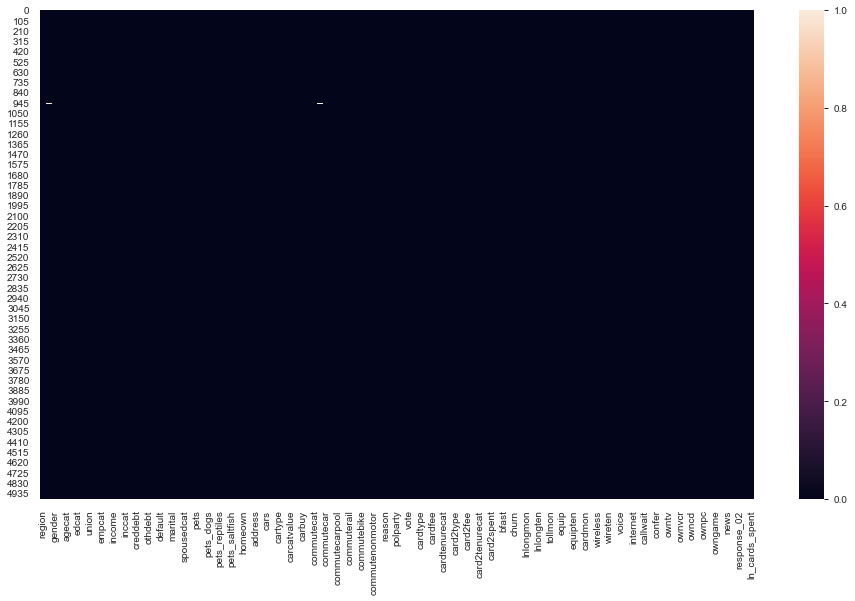

In [31]:
# Show the null values using heatmap
plt.figure(figsize=(16,9))
sns.heatmap(credit_card.isnull())

# Treating Outliners

In [32]:
# continuous variables
conti_vars = conti_vars.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

In [33]:
conti_vars.apply(continuous_var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
region,5000.0,0.0,15007.000000,3.001400,3.000000,1.421760,2.021402,1.00000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,5.000000,5.000000,5.00000,5.000000
townsize,4998.0,2.0,13431.000000,2.687275,3.000000,1.425925,2.033262,1.00000,1.000000,1.000000,1.000000,1.000000,3.000000,4.000000,5.000000,5.000000,5.00000,5.000000
age,5000.0,0.0,235128.000000,47.025600,47.000000,17.770338,315.784902,18.00000,18.000000,20.000000,23.000000,31.000000,47.000000,62.000000,72.000000,76.000000,79.00000,79.000000
agecat,5000.0,0.0,21194.000000,4.238800,4.000000,1.308785,1.712917,2.00000,2.000000,2.000000,2.000000,3.000000,4.000000,5.000000,6.000000,6.000000,6.00000,6.000000
ed,5000.0,0.0,72721.000000,14.544200,14.000000,3.242553,10.514149,8.00000,8.000000,9.000000,10.000000,12.000000,14.000000,17.000000,19.000000,20.000000,21.00000,21.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
news,5000.0,0.0,2363.000000,0.472600,0.000000,0.499299,0.249299,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000
response_01,5000.0,0.0,418.000000,0.083600,0.000000,0.276815,0.076626,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000
response_02,5000.0,0.0,649.000000,0.129800,0.000000,0.336117,0.112975,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000,1.000000
response_03,5000.0,0.0,513.000000,0.102600,0.000000,0.303466,0.092092,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000,1.000000


# Missing value treating

In [34]:
#for categorical and continuous variables
conti_vars = conti_vars.apply(missing_imputation)
cat_vars = cat_vars.apply(missing_imputation)

In [35]:
conti_vars.apply(continuous_var_summary).T.round(1)
cat_vars.apply(categorical_var_summary).T.round(1)

,N,NMISS,MODE,FREQ,PERCENT
gender,5000.0,0.0,1.0,2518.0,50.4
jobcat,5000.0,0.0,2.0,1640.0,32.8
union,5000.0,0.0,0.0,4244.0,84.9
retire,5000.0,0.0,0.0,4262.0,85.2
default,5000.0,0.0,0.0,3829.0,76.6
marital,5000.0,0.0,0.0,2599.0,52.0
homeown,5000.0,0.0,1.0,3148.0,63.0
hometype,5000.0,0.0,1.0,2265.0,45.3
carown,5000.0,0.0,1.0,3704.0,74.1
cartype,5000.0,0.0,0.0,2287.0,45.7


# Dummy Creation

In [36]:
cat_vars = credit_card[['gender','jobcat', 'union','retire','default','marital','homeown','hometype','carown','cartype','carcatvalue','carbought','carbuy',
                 'commutecat','reason','polview','card','cardtype','cardbenefit','cardfee','cardtenurecat','card2','card2type','card2benefit','card2fee',
                 'card2tenurecat','bfast','internet']]

# for c_feature in categorical_features
for c_feature in ['gender','jobcat', 'union','retire','default','marital','homeown','hometype','carown','cartype','carcatvalue','carbought','carbuy',
                 'commutecat','reason','polview','card','cardtype','cardbenefit','cardfee','cardtenurecat','card2','card2type','card2benefit','card2fee',
                 'card2tenurecat','bfast','internet']:
    cat_vars[c_feature] = cat_vars[c_feature].astype('category')
    cat_vars = create_dummies(cat_vars, c_feature)
 

cat_vars.head()

C:\Users\Yash\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,gender_1,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,retire_1,default_1,marital_1,...,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4
0,1,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0


In [37]:
#concat categorical and Continious features

In [38]:
credit_card = pd.concat([conti_vars, cat_vars], axis = 1)
credit_card.head()

,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,...,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4
0,1,2.0,20,2,15,3,0,1,31.0,3.433987,...,1,0,0,0,0,1,0,0,0,0
1,5,5.0,22,2,17,4,0,1,15.0,2.708050,...,1,0,0,0,0,0,0,0,0,1
2,3,4.0,67,6,14,2,16,5,35.0,3.555348,...,0,0,0,1,0,1,0,0,0,0
3,4,3.0,23,2,16,3,0,1,20.0,2.995732,...,1,0,0,0,0,0,0,1,0,0
4,2,2.0,26,3,16,3,1,1,23.0,3.135494,...,0,1,0,0,0,1,0,0,1,0


In [39]:
# Calculating cards spent by using two different card types spent 

In [40]:
credit_card['cards_spent']=credit_card.cardspent+credit_card.card2spent
credit_card.cards_spent.head()
credit_card.drop(columns=['cardspent','card2spent'],inplace=True)

In [41]:
credit_card.columns.size

166

In [42]:
credit_card.dtypes.value_counts()

uint8      74
int64      68
float64    24
dtype: int64

# Train/test

In [43]:
feature_columns = credit_card.columns.difference( ['cards_spent'] )
train_X, test_X, train_y, test_y = train_test_split(credit_card[feature_columns],
                                                  credit_card['cards_spent'],
                                                  test_size=0.3,
                                                  random_state=125)

In [44]:
print (len( train_X ))
print (len (train_y))
print (len( test_X))
print (len( test_y))
print (credit_card.shape)

3500
3500
1500
1500
(5000, 166)


In [45]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score

def test_model(model, train_X=train_X, train_y=train_y):
    cv = KFold(n_splits = 3, shuffle=True, random_state = 45)
    r2 = make_scorer(r2_score)
    r2_val_score = cross_val_score(model, train_X, train_y, cv=cv, scoring = r2)
    score = [r2_val_score.mean()]
    return score# Linear Regression



In [46]:
import sklearn.linear_model as linear_model
LR = linear_model.LinearRegression()
test_model(LR)

# Cross validation
cross_validation = cross_val_score(estimator = LR, X = train_X, y = train_y, cv = 10)
print("Cross validation accuracy of LR model = ", cross_validation)
print("\nCross validation mean accuracy of LR model = ", cross_validation.mean())

rdg = linear_model.Ridge()
test_model(rdg)

lasso = linear_model.Lasso(alpha=1e-4)
test_model(lasso)


C:\Users\Yash\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Yash\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Yash\anaconda3\lib\site-packages\sklearn\linear_model\_base.py", line 547, in fit
    linalg.lstsq(X, y)
  File "C:\Users\Yash\anaconda3\lib\site-packages\scipy\linalg\basic.py", line 1223, in lstsq
    raise LinAlgError("SVD did not converge in Linear Least Squares")
numpy.linalg.LinAlgError: SVD did not converge in Linear Least Squares

  FitFailedWarning)


Cross validation accuracy of LR model =  [0.75025083 0.74278842 0.72762546 0.7867421  0.76696571 0.70022073
 0.75012477 0.77067493 0.72846773 0.77752507]

Cross validation mean accuracy of LR model =  0.7501385739035424


C:\Users\Yash\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25649485.239074275, tolerance: 23800.074293877275
  positive)
C:\Users\Yash\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26240724.587204985, tolerance: 23434.75292195251
  positive)
C:\Users\Yash\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26459239.163790654, tolerance: 24800.938092456705
  positive)


[0.745984516036291]

# Linear Regression

In [47]:
import sklearn.linear_model as linear_model
LR = linear_model.LinearRegression()
test_model(LR)

[0.7459803618410116]

In [48]:
# Cross validation
cross_validation = cross_val_score(estimator = LR, X = train_X, y = train_y, cv = 10)
print("Cross validation accuracy of LR model = ", cross_validation)
print("\nCross validation mean accuracy of LR model = ", cross_validation.mean())

Cross validation accuracy of LR model =  [0.75025083 0.74278842 0.72762546 0.7867421  0.76696571 0.70022073
 0.75012477 0.77067493 0.72846773 0.77752507]

Cross validation mean accuracy of LR model =  0.7501385739035424


In [49]:
rdg = linear_model.Ridge()
test_model(rdg)

[0.7462296041178451]

In [50]:
lasso = linear_model.Lasso(alpha=1e-4)
test_model(lasso)

C:\Users\Yash\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25649485.239074275, tolerance: 23800.074293877275
  positive)
C:\Users\Yash\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26240724.587204985, tolerance: 23434.75292195251
  positive)
C:\Users\Yash\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26459239.163790654, tolerance: 24800.938092456705
  positive)


[0.745984516036291]

# Support Vector Machine

In [51]:
from sklearn.svm import SVR
svr_reg = SVR(kernel='rbf')
test_model(svr_reg)

[-0.05396602512732107]

# Decision Tree Regressor

In [52]:
from sklearn.svm import SVR
svr_reg = SVR(kernel='rbf')
test_model(svr_reg)

[-0.05396602512732107]

 # Bagging & boosting

In [53]:
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
br_reg = BaggingRegressor(n_estimators=1000, random_state=51)
gbr_reg = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, loss='ls', random_state=51)

In [54]:
test_model(br_reg)

[0.8803239204548526]

In [55]:
test_model(gbr_reg)

[0.8722686537966372]

# XGBoost

In [56]:
import xgboost
#xgb_reg=xgboost.XGBRegressor()
xgb_reg = xgboost.XGBRegressor(bbooster='gbtree', random_state=51)
test_model(xgb_reg)

[13:14:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { bbooster } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { bbooster } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:14:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { bbooster } might not be used.

  This may not be accurate due to some parameters are only used in language bindi

[0.8643550718564685]

# SVM Model Bulding Hyperparameter Tuning 

# Hyperparameter Tuning 

In [57]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
params = {'kernel': ['rbf'],
         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
         'C': [0.1, 1, 10, 100, 1000],
         'epsilon': [1, 0.2, 0.1, 0.01, 0.001, 0.0001]}
rand_search = RandomizedSearchCV(svr_reg, param_distributions=params, n_jobs=-1, cv=11)
rand_search.fit(train_X, train_y)
rand_search.best_score_

-0.005186737441078903

In [58]:
svr_reg= SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.0001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
test_model(svr_reg)

[-0.03417020819309383]

In [59]:
svr_reg.fit(train_X,train_y)
y_pred = np.exp(svr_reg.predict(train_X)).round(2)

In [60]:
y_pred

array([2.12704821e+231, 2.48136552e+231, 5.70717206e+205, ...,
       2.41440176e+265, 4.01001176e+169, 2.43483019e+278])

In [61]:
from sklearn.ensemble import RandomForestRegressor
clf_rf= RandomForestRegressor(n_estimators=100)
clf_rf.fit(train_X, train_y)
y_pred_rf= clf_rf.predict(test_X)
acc_rf = round( clf_rf.score(test_X,test_y) * 100, 2)
print (str(acc_rf) + ' percent')

87.67 percent


In [62]:
from sklearn.tree import DecisionTreeRegressor
clf_dt=DecisionTreeRegressor()
clf_dt.fit(train_X, train_y)
y_pred_dt= clf_dt.predict(test_X)
acc_dt = round( clf_dt.score(test_X, test_y) * 100, 2)
print (str(acc_dt) + ' percent')

75.64 percent


In [63]:
import statsmodels.api as sm

#OrdinaryLeastSquares
regressor_OLS = sm.OLS(endog=train_y, exog=train_X).fit()

lm=sm.OLS(train_y,train_X).fit()

In [64]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            cards_spent   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              258.1
Date:                Sat, 18 Jul 2020   Prob (F-statistic):                        0.00
Time:                        13:15:51   Log-Likelihood:                         -22724.
No. Observations:                3500   AIC:                                  4.577e+04
Df Residuals:                    3338   BIC:                                  4.677e+04
Df Model:                         162                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
active                2.1967      5.995      0.366      0.714      -9.558      13.951
address               0.7036      0.722      0.974      0.330      -0.713       2.120
addresscat           -4.9927      6.885     -0.725      0.468     -18.492       8.506
age                  -1.0994      0.799     -1.377      0.169      -2.665       0.466
agecat               -0.0045      9.601     -0.000      1.000     -18.829      18.820
bfast_2               6.2856      8.955      0.702      0.483     -11.273      23.844
bfast_3              -8.4945      7.182     -1.183      0.237     -22.576       5.587
callcard            -20.7844     10.411     -1.996      0.046     -41.198      -0.371
callid              -13.4925      8.488     -1.590      0.112     -30.135       3.150
callwait             -0.3033      8.409     -0.036      0.971     -16.791      16.185
carbought_0          -7.9695      5.953     -1.339      0.181     -19.642       3.703
carbought_1          -7.4838      6.322     -1.184      0.237     -19.880       4.912
carbuy_1             -0.0066      6.121     -0.001      0.999     -12.008      11.994
carcatvalue_1       -26.5866      7.852     -3.386      0.001     -41.982     -11.191
carcatvalue_2        23.7359      5.720      4.149      0.000      12.520      34.951
carcatvalue_3       -12.6026     13.972     -0.902      0.367     -39.997      14.791
card2_2             -70.3409      9.342     -7.530      0.000     -88.657     -52.025
card2_3             -69.1676      9.291     -7.445      0.000     -87.384     -50.951
card2_4             -71.3678     10.249     -6.963      0.000     -91.463     -51.273
card2_5             -74.3472     13.615     -5.461      0.000    -101.042     -47.652
card2benefit_2       -2.2366      8.066     -0.277      0.782     -18.052      13.579
card2benefit_3       -0.7268      7.984     -0.091      0.927     -16.380      14.927
card2benefit_4       -9.7472      8.015     -1.216      0.224     -25.462       5.967
card2fee_1          -16.1153      7.309     -2.205      0.028     -30.446      -1.784
card2tenure          -2.1016      1.835     -1.145      0.252      -5.700       1.496
card2tenurecat_2      2.5481     21.136      0.121      0.904     -38.893      43.989
card2tenurecat_3     14.6232     26.278      0.556      0.578     -36.899      66.145
card2tenurecat_4     33.8158     31.214      1.083      0.279     -27.385      95.017
card2tenurecat_5     35.3985     36.857      0.960      0.337     -36.867     107.664
card2type_2          -9.1549      8.069     -1.135      0.257     -24.975       6.665
card2type_3          -1.8079      8.112     -0.223      0.824     -17.713      14.098
card2type_4          -5.7908      7.957     -0.728      0.46

In [65]:
clf_rf.feature_importances_
list(zip(train_X.columns,clf_rf.feature_importances_ ))

[('active', 0.0005052191785093754),
 ('address', 0.0018775657438047568),
 ('addresscat', 0.0002650665445302386),
 ('age', 0.0016760104374514283),
 ('agecat', 0.0002697920651405047),
 ('bfast_2', 0.00035151674697168455),
 ('bfast_3', 0.00041978597022124036),
 ('callcard', 9.589686139432581e-05),
 ('callid', 0.000271791702656013),
 ('callwait', 0.00025042044234896085),
 ('carbought_0', 0.0002828625189581102),
 ('carbought_1', 0.0003409782915840904),
 ('carbuy_1', 0.0004778470644806887),
 ('carcatvalue_1', 0.00014186076830925782),
 ('carcatvalue_2', 0.000238050053927964),
 ('carcatvalue_3', 0.00010045492928779337),
 ('card2_2', 0.0003756916964804139),
 ('card2_3', 0.0006224536263936186),
 ('card2_4', 0.0004210842525230882),
 ('card2_5', 0.00015096283928793931),
 ('card2benefit_2', 0.0005473806510851031),
 ('card2benefit_3', 0.0002697016758119609),
 ('card2benefit_4', 0.0002943393197387256),
 ('card2fee_1', 0.0002952043557188694),
 ('card2tenure', 0.0012048209656443493),
 ('card2tenurecat_

In [66]:
center=pd.DataFrame(clf_rf.feature_importances_, train_X.columns)
center.columns=['Coefficients']
center.sort_values('Coefficients',ascending=False,inplace=True)
center['Coefficients']=((center['Coefficients'])*100).round(2)
center=center.head(10)

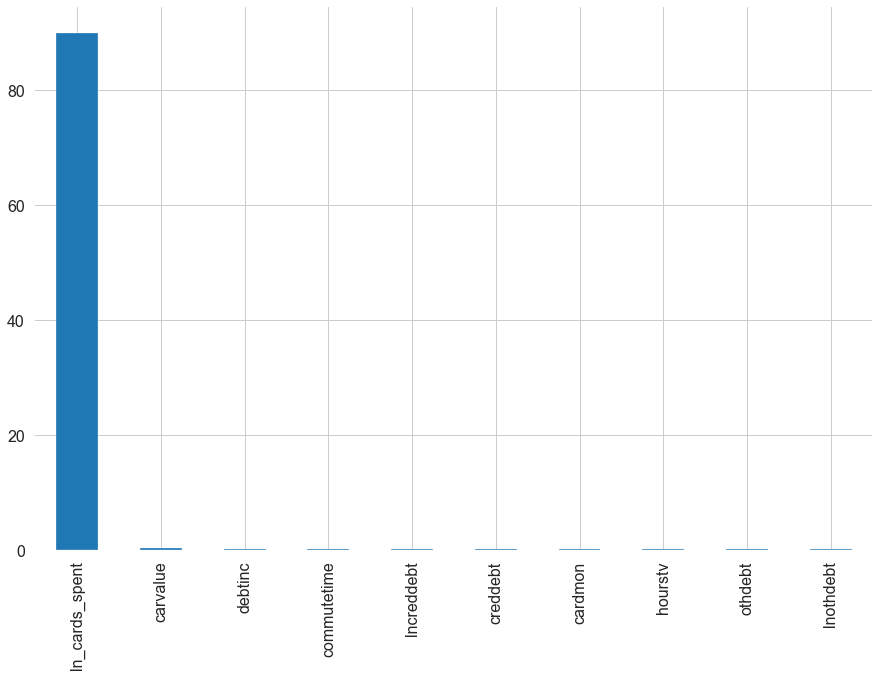

In [67]:
coff=center.head(12)
center.Coefficients.plot(kind='bar',figsize=(15,10),fontsize=16)
plt.show()

# Feature Engineering / Selection to improve accuracy


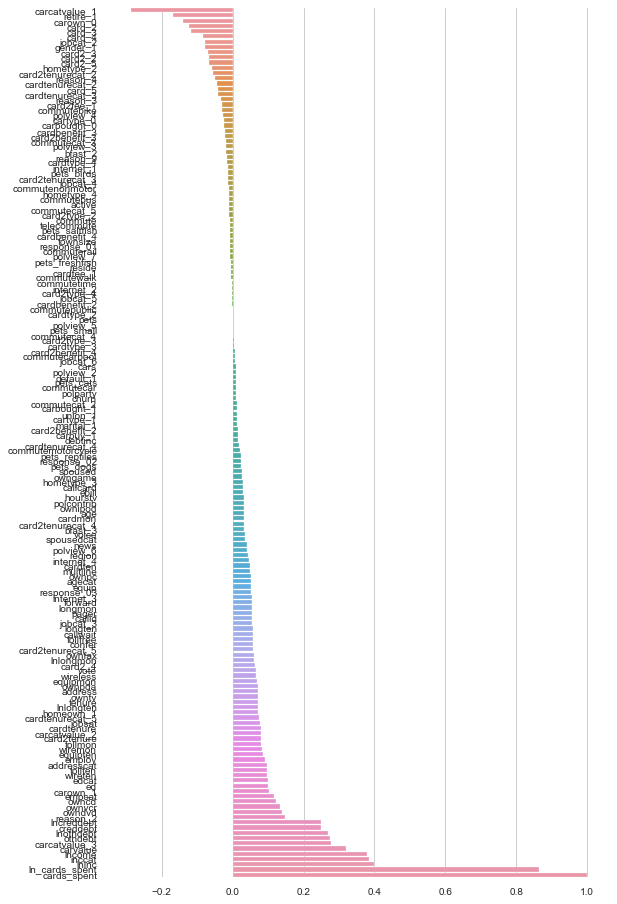

In [68]:
# correlation Barplot
plt.figure(figsize=(9,16))
corr_feat_series = pd.Series.sort_values(credit_card.corrwith(credit_card.cards_spent))
sns.barplot(x=corr_feat_series, y=corr_feat_series.index, orient='h')

In [69]:
list(corr_feat_series.index)

['carcatvalue_1',
 'retire_1',
 'carown_0',
 'card_2',
 'card_3',
 'card_4',
 'jobcat_2',
 'gender_1',
 'card2_3',
 'card2_2',
 'card2_5',
 'hometype_2',
 'card2tenurecat_2',
 'reason_4',
 'cardtenurecat_2',
 'card_5',
 'cardtenurecat_3',
 'reason_3',
 'card2fee_1',
 'commutebike',
 'polview_4',
 'cartype_0',
 'carbought_0',
 'cardbenefit_3',
 'card2benefit_3',
 'commutecat_3',
 'polview_3',
 'bfast_2',
 'reason_9',
 'cardtype_4',
 'internet_1',
 'pets_birds',
 'card2tenurecat_3',
 'jobcat_4',
 'commutenonmotor',
 'hometype_4',
 'commutebus',
 'active',
 'commutecat_5',
 'card2type_2',
 'commute',
 'telecommute',
 'pets_saltfish',
 'cardbenefit_4',
 'townsize',
 'response_01',
 'commuterail',
 'polview_7',
 'pets_freshfish',
 'reside',
 'cardfee_1',
 'commutewalk',
 'commutetime',
 'internet_2',
 'card2type_4',
 'jobcat_5',
 'cardbenefit_2',
 'commutepublic',
 'cardtype_2',
 'pets',
 'polview_5',
 'pets_small',
 'commutecat_4',
 'card2type_3',
 'cardtype_3',
 'card2benefit_4',
 'commut